In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt
import time
import networkx as nx
import numpy as np
from copy import deepcopy
from pprint import pprint
from tqdm import tqdm
import random
from collections import Counter
import os
import pickle

### Preprocessing

Reading in the graph and removing nodes with degree of 2, but keeping connectivity. Removes nodes not part of the large component, and adds attributes 'weight' and 'flow' to edges, all equal to 1.

In [2]:
# //TODO: Change path to file, but keep name "australia" even if it is, in fact, not Australia
australia = nx.read_gpickle('australia.gpickle')

In [3]:
def remove_useless_nodes(G):
    """
    Removes (in-place) nodes with degree 2 but preserves connectivity
    """
    while list(dict(G.degree()).values()).count(2):
        deg = dict(G.degree())
        for node in deg:
            if deg[node] == 2:
                neigh = list(G.neighbors(node))
                if len(neigh) == 1:
                    break
                G.add_edge(neigh[0], neigh[1])
                G.remove_node(node)
    return G

In [4]:
new_aus = deepcopy(australia)
new_aus = remove_useless_nodes(new_aus)
G = None
best = 0
for x in nx.connected_component_subgraphs(new_aus):
    size = len(x.nodes)
    if size > best:
        best = size
        G = x
nx.set_edge_attributes(G, 1, 'weight')
nx.set_edge_attributes(G, 1, 'flow')

### Betweenness

The most central nodes are on the long roads through the desert seperating west and east

In [5]:
betweenness = nx.betweenness_centrality(new_aus, k=100)
bet = [[a,b] for b,a in betweenness.items()]
bet.sort(reverse=True)
bet[:5]

[[0.28583282035150986, 460],
 [0.2838570950599364, 16730],
 [0.23442264823918815, 10215],
 [0.23374624967676838, 12825],
 [0.23276364332257943, 12180]]

### Average path length estimation

In [6]:
def mean(s):
    return sum(s) / len(s)

def estimate_ave_path_length(G, N):
    means = []
    running_mean = []
    nodes = list(G.nodes)
    nodes = random.sample(nodes, N)
    for node in tqdm(nodes):
        new = list(nx.single_source_dijkstra_path_length(G, node).values())
        means.append(mean(new))
        running_mean.append(mean(means))
    return running_mean[-1], running_mean

100%|████████████████████████████████████████| 200/200 [00:14<00:00, 13.69it/s]


<IPython.core.display.Javascript object>


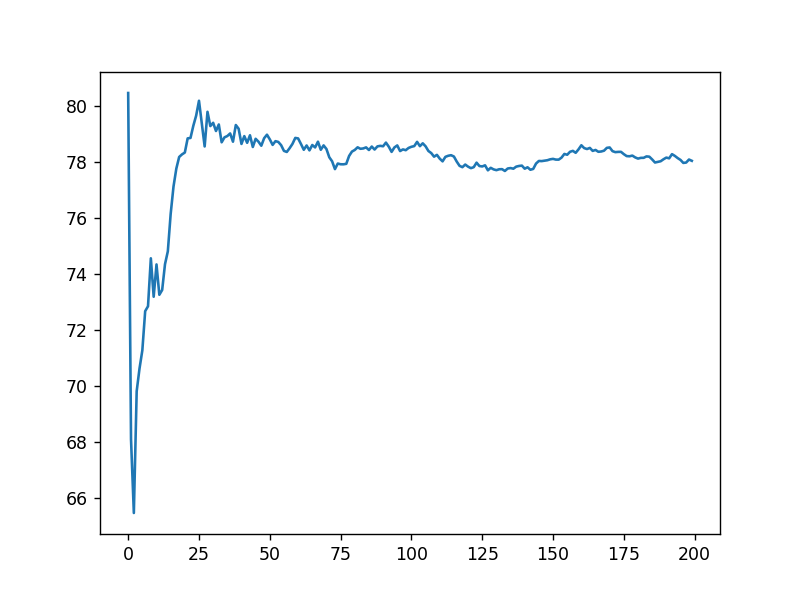

78.04294019838316


In [7]:
est, prog = estimate_ave_path_length(G, 200)
plt.plot(range(len(prog)),prog)
plt.show()
print(est)

### Some properties of the network

In [8]:
print('Number of nodes: {}'.format(len(G.nodes)))
print('Average path length: {}'.format(est))
print('Clustering coefficient: {}'.format(nx.average_clustering(G)))
print('Degree distribution:', end=' ')
pprint(dict(Counter(list(dict(G.degree).values()))))


Number of nodes: 17441
Average path length: 78.04294019838316
Clustering coefficient: 0.054817056689083855
Degree distribution: {1: 1753, 3: 13532, 4: 2064, 5: 78, 6: 8, 7: 5, 8: 1}


In [9]:
deg = dict(G.degree)
m = max(deg.values())
for key in deg:
    if deg[key]==m:
        print('Coordinates of node with largest degree ({}): {}'.format(m,G.node[key]['coords']))
        break

Coordinates of node with largest degree (8): (151.11534000000006, -29.78007999999994)


## The algorithm

Take two random nodes, and their neighborhoods. Take one neighborhood as sink, one as source. Calculate max flow between them and increase capacity of roads used, decreasing capacity of others to normalize. Repeat.

In [10]:
def euclid_dist(n1, n2):
    """Pythagoras"""
    return ((n1[0] - n2[0])**2 + (n1[1] - n2[1])**2 ) **.5

def max_flow_neighborhood(G, sourcecoords=None, sinkcoords=None, radius=1, flowattr='flow'):
    """
    Takes a graph, and chooses a source and sink randomly unless gives. Calcluates and returns 
    max flow between source and sink.
    """
    assert (sourcecoords is None and sinkcoords is None) or (sourcecoords and sinkcoords), "Either both source and sink have to be given, or neither."
    
    if sourcecoords is None:
        dist = float('-inf')
        while dist < radius * 2:
            sourcecenter = random.choice(list(G.nodes))
            sourcecoords = G.node[sourcecenter]['coords']

            sinkcenter = random.choice(list(G.nodes))
            sinkcoords = G.node[sinkcenter]['coords']

            dist = euclid_dist(sourcecoords, sinkcoords)
    else:
        assert euclid_dist(sourcecoords, sinkcoords) > radius * 2, "Source and sink ranges overlap."
                
    G.add_node('SOURCE')
    G.add_node('SINK')

    for node in G:
        if node == 'SOURCE' or node == 'SINK':
            continue
        if euclid_dist(G.node[node]['coords'], sourcecoords) < radius:
            G.add_edge('SOURCE', node, flowattr = 10**20) # infinite, but float('inf') might not work
        if euclid_dist(G.node[node]['coords'], sinkcoords) < radius:
            G.add_edge('SINK', node, flowattr = 10**20)
            
    max_flow, flow = nx.maximum_flow(G, 'SOURCE', 'SINK', capacity=flowattr)
    G.remove_node('SINK')
    G.remove_node('SOURCE')
    return max_flow, flow
    

In [24]:
def max_flow_iteration(G, N, inc_ratio_func, radius=1, flowattr='flow', copy=True, continent_name="Australia"):
    """
    Calls max_flow_neighborhood N times, using the flow to increase capacity
    of roads of which flow was used, and normalizes. Returns the max flow of
    each iteration and the resulting graph.
    """
    if copy:
        G = deepcopy(G)

    max_flow_prog = []
    for n in tqdm(range(N)):
        if not n % 200:
            save_graph(G, continent_name, str(n))
        
        max_flow, flow = max_flow_neighborhood(G)
        max_flow_prog.append(max_flow)
        
        done = set()
        
        for key1 in flow:
            if key1 in ['SOURCE', 'SINK']:
                continue
            for key2 in flow[key1]:
                if key2 in ['SOURCE', 'SINK'] or (key2, key1) in done:
                    continue
                f = flow[key1][key2]
                if f > 0:
                    max_flow = G[key1][key2]['flow']
                    G[key1][key2]['flow'] += inc_ratio_func(n) * f / max_flow
                done.add((key1, key2))
        flows = nx.get_edge_attributes(G, 'flow')
        frac = sum(flows.values()) / len(flows)
        flows.update((x,y/frac) for x, y in flows.items())
        nx.set_edge_attributes(G, flows, 'flow')
    
    save_graph(G, continent_name, "FinalResult")
    return max_flow_prog, G

def save_graph(G, name, it):
    if not os.path.exists('Graph_GPickles'):
        os.makedirs('Graph_GPickles')
    nx.write_gpickle(G, "./Graph_GPickles/{}_{}.gpickle".format(name, it))

In [28]:
# //TODO: *DO* change the name of the continent here, it saves the graphs in a file based on the string 
continent = "Australia"
a, resulting_graph = max_flow_iteration(G, 10000, lambda x: 1/(5+x/100), continent_name = continent)

with open('./Graph_Gpickles/{}_MaxFlowList.pkl'.format(continent), 'wb') as f:
    pickle.dump(a, f)


100%|██████████████████████████████████████████| 10/10 [00:38<00:00,  3.87s/it]


# You can ignore everything below these lines
---

---

---

<IPython.core.display.Javascript object>


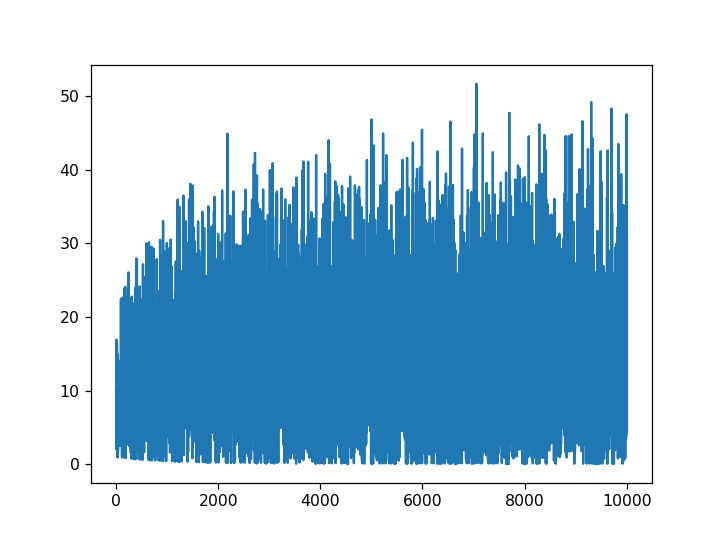

In [12]:
plt.figure()
plt.plot(range(len(a)), a)
plt.show()

<IPython.core.display.Javascript object>


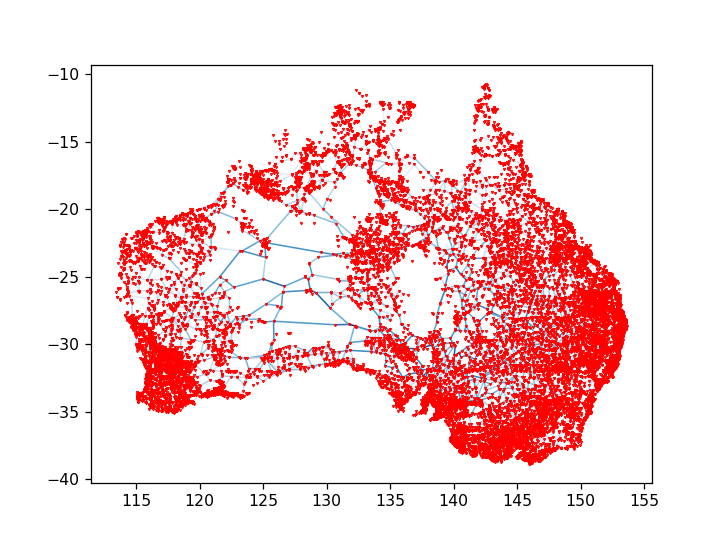

In [13]:
def plot_graph(G, weight_attr='flow'):
    """Plot networkx graph. Whereby position is given by coords attribute"""
    plt.figure()

    # positions for all nodes
    pos = nx.get_node_attributes(G, "coords")

    # nodes
    nx.draw_networkx_nodes(G, pos = pos, node_size=1, node_color='r', node_shape='v')

    # colour edges based on their weights
    edges, weights = zip(*nx.get_edge_attributes(G,weight_attr).items())
    nx.draw_networkx_edges(G, pos = pos, edgelist=edges, edge_color=weights, width=1, edge_cmap=plt.cm.Blues)
    #nx.draw(G, pos = pos)

    #small_df.plot()
    plt.show()
plot_graph(resulting_graph)

The flow between west and east coast does seem to increase

In [19]:
print(max_flow_neighborhood(G, (117, -34), (151, -27))[0])
print(max_flow_neighborhood(resulting_graph, (117, -34), (151, -27))[0])

print(max_flow_neighborhood(G, (117, -26), (145, -27))[0])
print(max_flow_neighborhood(resulting_graph, (117, -26), (145, -27))[0])

9
9.255244919893464
9
9.255244919893467


In [17]:
nx.write_gpickle(resulting_graph, "resulting_graph")

In [23]:
save_graph(G, 'test', '123')